# Preprocessing Validation: 5/95 Stress Test

stress testing preprocessing with extreme 5/95 split using sklearn pipelines and monte carlo cv

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## load data

In [112]:
df = pd.read_csv('data_cleaned.csv')

X = df.drop(columns=['Species'])
y = df['Species']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"samples: {len(df)}, features: {X.shape[1]}")
print(f"missing: {df.isna().sum().sum()}")

samples: 342, features: 10
missing: 32


## define pipelines

In [113]:
numerical_features = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 
                      'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
sex_feature = ['Sex']

baseline_preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_features),
    ('sex', SimpleImputer(strategy='most_frequent'), sex_feature)
], remainder='passthrough')

optimal_preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', IterativeImputer(random_state=42, max_iter=10)),
        ('scaler', StandardScaler())
    ]), numerical_features),
    ('sex', Pipeline([
        ('imputer', IterativeImputer(random_state=42, max_iter=10)),
        ('scaler', StandardScaler())
    ]), sex_feature)
], remainder='passthrough')

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='mlogloss')
}

## monte carlo cv: baseline

In [114]:
n_iterations = 100
baseline_results = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for name in models.keys()}

for i in range(n_iterations):
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(
        X, y_encoded, test_size=0.95, stratify=y_encoded, random_state=i
    )
    
    for name, model in models.items():
        pipe = Pipeline([
            ('preprocessor', baseline_preprocessor),
            ('classifier', model)
        ])
        
        pipe.fit(X_train_iter, y_train_iter)
        y_pred = pipe.predict(X_test_iter)
        
        baseline_results[name]['accuracy'].append(accuracy_score(y_test_iter, y_pred))
        baseline_results[name]['precision'].append(precision_score(y_test_iter, y_pred, average='macro'))
        baseline_results[name]['recall'].append(recall_score(y_test_iter, y_pred, average='macro'))
        baseline_results[name]['f1'].append(f1_score(y_test_iter, y_pred, average='macro'))
    
    if (i + 1) % 20 == 0:
        print(f"completed {i + 1}/{n_iterations}")

baseline_summary = {name: {
    'accuracy_mean': np.mean(scores['accuracy']),
    'accuracy_std': np.std(scores['accuracy']),
    'precision_mean': np.mean(scores['precision']),
    'precision_std': np.std(scores['precision']),
    'recall_mean': np.mean(scores['recall']),
    'recall_std': np.std(scores['recall']),
    'f1_mean': np.mean(scores['f1']),
    'f1_std': np.std(scores['f1'])
} for name, scores in baseline_results.items()}

completed 20/100
completed 40/100
completed 60/100
completed 80/100
completed 100/100


## baseline results

In [115]:
for name, stats in baseline_summary.items():
    print(f"{name}:")
    print(f"  accuracy:  {stats['accuracy_mean']:.4f} ± {stats['accuracy_std']:.4f}")
    print(f"  precision: {stats['precision_mean']:.4f} ± {stats['precision_std']:.4f}")
    print(f"  recall:    {stats['recall_mean']:.4f} ± {stats['recall_std']:.4f}")
    print(f"  f1:        {stats['f1_mean']:.4f} ± {stats['f1_std']:.4f}")
    print()

Logistic Regression:
  accuracy:  0.9477 ± 0.0523
  precision: 0.9491 ± 0.0526
  recall:    0.9387 ± 0.0581
  f1:        0.9410 ± 0.0579

Decision Tree:
  accuracy:  0.8938 ± 0.0448
  precision: 0.8861 ± 0.0478
  recall:    0.8817 ± 0.0552
  f1:        0.8795 ± 0.0541

Random Forest:
  accuracy:  0.9695 ± 0.0224
  precision: 0.9719 ± 0.0159
  recall:    0.9589 ± 0.0363
  f1:        0.9632 ± 0.0314

Gradient Boosting:
  accuracy:  0.9285 ± 0.0428
  precision: 0.9384 ± 0.0341
  recall:    0.9116 ± 0.0610
  f1:        0.9183 ± 0.0584

XGBoost:
  accuracy:  0.8672 ± 0.0582
  precision: 0.9034 ± 0.0328
  recall:    0.8261 ± 0.0779
  f1:        0.8411 ± 0.0776



## monte carlo cv: optimal with hyperparameter tuning

In [116]:
param_grids = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10], 'classifier__solver': ['lbfgs', 'liblinear']},
    'Decision Tree': {'classifier__max_depth': [3, 5, 10, None]},
    'Random Forest': {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10, None]},
    'Gradient Boosting': {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.01, 0.1]},
    'XGBoost': {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.01, 0.1]}
}

optimal_results = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for name in models.keys()}

for i in range(n_iterations):
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(
        X, y_encoded, test_size=0.95, stratify=y_encoded, random_state=i
    )
    
    for name, model in models.items():
        pipe = ImbPipeline([
            ('preprocessor', optimal_preprocessor),
            ('smote', SMOTE(random_state=42, k_neighbors=1)),
            ('classifier', model)
        ])
        
        grid = GridSearchCV(pipe, param_grids[name], cv=3, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train_iter, y_train_iter)
        y_pred = grid.predict(X_test_iter)
        
        optimal_results[name]['accuracy'].append(accuracy_score(y_test_iter, y_pred))
        optimal_results[name]['precision'].append(precision_score(y_test_iter, y_pred, average='macro'))
        optimal_results[name]['recall'].append(recall_score(y_test_iter, y_pred, average='macro'))
        optimal_results[name]['f1'].append(f1_score(y_test_iter, y_pred, average='macro'))
    
    if (i + 1) % 20 == 0:
        print(f"completed {i + 1}/{n_iterations}")

optimal_summary = {name: {
    'accuracy_mean': np.mean(scores['accuracy']),
    'accuracy_std': np.std(scores['accuracy']),
    'precision_mean': np.mean(scores['precision']),
    'precision_std': np.std(scores['precision']),
    'recall_mean': np.mean(scores['recall']),
    'recall_std': np.std(scores['recall']),
    'f1_mean': np.mean(scores['f1']),
    'f1_std': np.std(scores['f1'])
} for name, scores in optimal_results.items()}

completed 20/100
completed 40/100
completed 60/100
completed 80/100
completed 100/100


## optimal results

In [117]:
for name, stats in optimal_summary.items():
    print(f"{name}:")
    print(f"  accuracy:  {stats['accuracy_mean']:.4f} ± {stats['accuracy_std']:.4f}")
    print(f"  precision: {stats['precision_mean']:.4f} ± {stats['precision_std']:.4f}")
    print(f"  recall:    {stats['recall_mean']:.4f} ± {stats['recall_std']:.4f}")
    print(f"  f1:        {stats['f1_mean']:.4f} ± {stats['f1_std']:.4f}")
    print()

Logistic Regression:
  accuracy:  0.9786 ± 0.0157
  precision: 0.9719 ± 0.0192
  recall:    0.9797 ± 0.0174
  f1:        0.9746 ± 0.0185

Decision Tree:
  accuracy:  0.8994 ± 0.0503
  precision: 0.8909 ± 0.0524
  recall:    0.8877 ± 0.0561
  f1:        0.8843 ± 0.0578

Random Forest:
  accuracy:  0.9702 ± 0.0177
  precision: 0.9675 ± 0.0171
  recall:    0.9649 ± 0.0265
  f1:        0.9650 ± 0.0228

Gradient Boosting:
  accuracy:  0.9283 ± 0.0515
  precision: 0.9371 ± 0.0454
  recall:    0.9151 ± 0.0657
  f1:        0.9200 ± 0.0652

XGBoost:
  accuracy:  0.8595 ± 0.0640
  precision: 0.8863 ± 0.0547
  recall:    0.8273 ± 0.0819
  f1:        0.8375 ± 0.0822



## comparison

In [118]:
comparison = []
for name in models.keys():
    comparison.append({
        'model': name,
        'baseline_f1': baseline_summary[name]['f1_mean'],
        'baseline_std': baseline_summary[name]['f1_std'],
        'optimal_f1': optimal_summary[name]['f1_mean'],
        'optimal_std': optimal_summary[name]['f1_std'],
        'improvement': optimal_summary[name]['f1_mean'] - baseline_summary[name]['f1_mean']
    })

comparison_df = pd.DataFrame(comparison).sort_values('optimal_f1', ascending=False)
print(comparison_df.to_string(index=False))

              model  baseline_f1  baseline_std  optimal_f1  optimal_std  improvement
Logistic Regression     0.940991      0.057931    0.974632     0.018487     0.033640
      Random Forest     0.963178      0.031438    0.965028     0.022756     0.001850
  Gradient Boosting     0.918314      0.058381    0.920025     0.065176     0.001710
      Decision Tree     0.879509      0.054122    0.884307     0.057844     0.004798
            XGBoost     0.841067      0.077568    0.837460     0.082159    -0.003607


## visualization

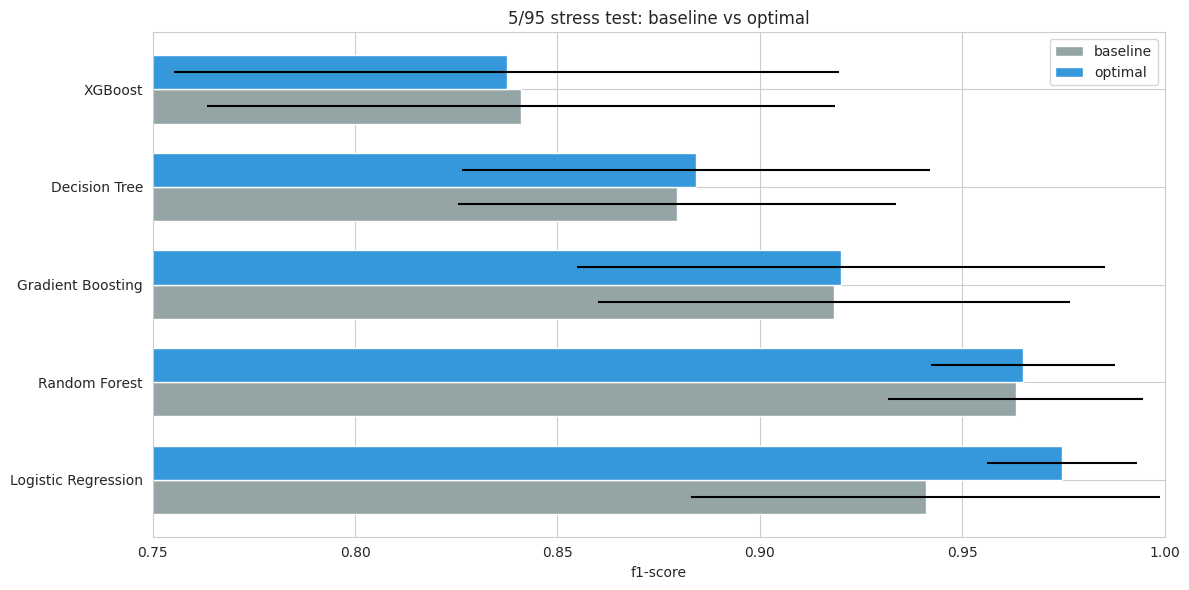

In [119]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

ax.barh(x - width/2, comparison_df['baseline_f1'], width, 
        label='baseline', color='#95a5a6', xerr=comparison_df['baseline_std'])
ax.barh(x + width/2, comparison_df['optimal_f1'], width,
        label='optimal', color='#3498db', xerr=comparison_df['optimal_std'])

ax.set_yticks(x)
ax.set_yticklabels(comparison_df['model'])
ax.set_xlabel('f1-score')
ax.set_title('5/95 stress test: baseline vs optimal')
ax.legend()
ax.set_xlim([0.75, 1.0])

plt.tight_layout()
plt.savefig('preprocessing_validation_5_95.png', dpi=150)
plt.show()

## ablation study

In [120]:
ablation_configs = {
    'baseline': baseline_preprocessor,
    'knn_imputer': ColumnTransformer([
        ('num', KNNImputer(n_neighbors=5), numerical_features),
        ('sex', KNNImputer(n_neighbors=5), sex_feature)
    ], remainder='passthrough'),
    'mice_imputer': ColumnTransformer([
        ('num', IterativeImputer(random_state=42, max_iter=10), numerical_features),
        ('sex', IterativeImputer(random_state=42, max_iter=10), sex_feature)
    ], remainder='passthrough'),
    'scaling_only': ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), 
                          ('scaler', StandardScaler())]), numerical_features),
        ('sex', SimpleImputer(strategy='most_frequent'), sex_feature)
    ], remainder='passthrough'),
    'full_pipeline': optimal_preprocessor
}

ablation_results = {}
model_for_ablation = LogisticRegression(random_state=42, max_iter=1000)

for config_name, preprocessor in ablation_configs.items():
    scores = []
    for i in range(50):
        X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(
            X, y_encoded, test_size=0.95, stratify=y_encoded, random_state=i
        )
        
        pipe = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, k_neighbors=1)),
            ('classifier', model_for_ablation)
        ])
        pipe.fit(X_train_iter, y_train_iter)
        y_pred = pipe.predict(X_test_iter)
        scores.append(f1_score(y_test_iter, y_pred, average='macro'))
    
    ablation_results[config_name] = {'mean': np.mean(scores), 'std': np.std(scores)}

print("ablation study (5/95 split):")
for name, stats in ablation_results.items():
    improvement = (stats['mean'] - ablation_results['baseline']['mean']) * 100
    print(f"{name}: {stats['mean']:.4f} ± {stats['std']:.4f} ({improvement:+.2f}%)")

ablation study (5/95 split):
baseline: 0.9390 ± 0.0577 (+0.00%)
knn_imputer: 0.9326 ± 0.0591 (-0.64%)
mice_imputer: 0.9326 ± 0.0585 (-0.64%)
scaling_only: 0.9793 ± 0.0132 (+4.03%)
full_pipeline: 0.9795 ± 0.0145 (+4.05%)


## ablation visualization

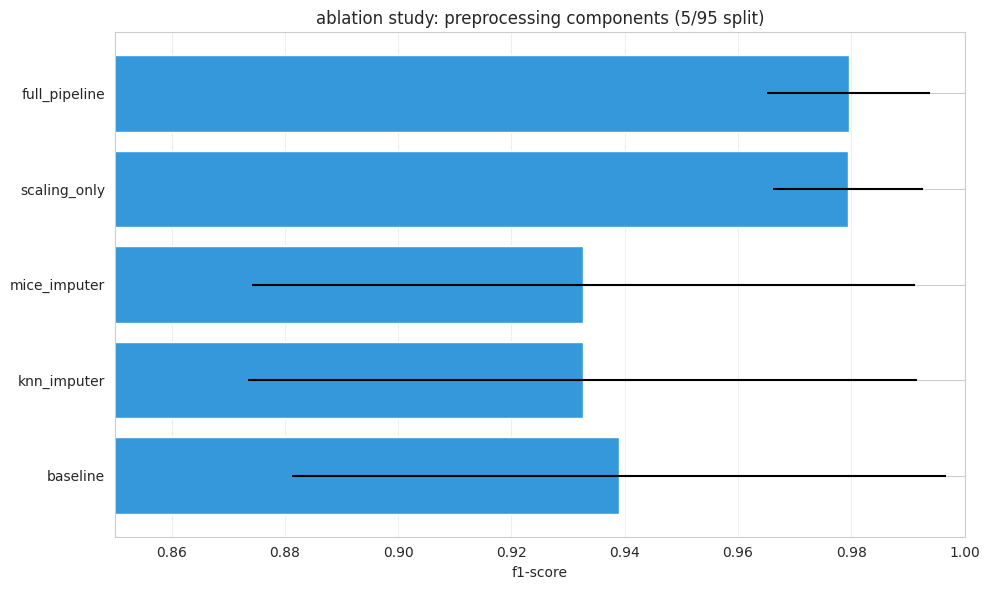

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))

names = list(ablation_results.keys())
means = [ablation_results[n]['mean'] for n in names]
stds = [ablation_results[n]['std'] for n in names]

ax.barh(names, means, xerr=stds, color='#3498db')
ax.set_xlabel('f1-score')
ax.set_title('ablation study: preprocessing components (5/95 split)')
ax.set_xlim([0.85, 1.0])
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('ablation_study_5_95.png', dpi=150)
plt.show()

## results analysis



In [122]:
X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(
    X, y_encoded, test_size=0.95, stratify=y_encoded, random_state=42
)

print(f"before preprocessing:")
print(f"  X_train has {X_train_test.isna().sum().sum()} NaN values")
print(f"  X_test has {X_test_test.isna().sum().sum()} NaN values")

X_train_transformed = optimal_preprocessor.fit_transform(X_train_test)
X_test_transformed = optimal_preprocessor.transform(X_test_test)

print(f"\nafter preprocessing:")
print(f"  X_train has {np.isnan(X_train_transformed).sum()} NaN values")
print(f"  X_test has {np.isnan(X_test_transformed).sum()} NaN values")

if np.isnan(X_train_transformed).sum() == 0 and np.isnan(X_test_transformed).sum() == 0:
    print("\nverification passed: pipeline correctly imputes all missing values")
else:
    print("\nWARNING: pipeline still has NaN values after preprocessing!")

before preprocessing:
  X_train has 0 NaN values
  X_test has 32 NaN values

after preprocessing:
  X_train has 0 NaN values
  X_test has 0 NaN values

verification passed: pipeline correctly imputes all missing values


## verify no nan values after preprocessing

In [123]:
tuning_no_tuning = {}
tuning_with_tuning = {}
param_grid = {'classifier__C': [0.1, 1, 10], 'classifier__solver': ['lbfgs', 'liblinear']}

for config_name, preprocessor in ablation_configs.items():
    scores_no = []
    scores_with = []
    
    for i in range(50):
        X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(
            X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=i
        )
        
        pipe_no = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, k_neighbors=5)),
            ('classifier', model_for_ablation)
        ])
        pipe_no.fit(X_train_iter, y_train_iter)
        y_pred_no = pipe_no.predict(X_test_iter)
        scores_no.append(f1_score(y_test_iter, y_pred_no, average='macro'))
        
        pipe_with = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, k_neighbors=5)),
            ('classifier', model_for_ablation)
        ])
        grid = GridSearchCV(pipe_with, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train_iter, y_train_iter)
        y_pred_with = grid.predict(X_test_iter)
        scores_with.append(f1_score(y_test_iter, y_pred_with, average='macro'))
    
    tuning_no_tuning[config_name] = {'mean': np.mean(scores_no), 'std': np.std(scores_no)}
    tuning_with_tuning[config_name] = {'mean': np.mean(scores_with), 'std': np.std(scores_with)}

print("no tuning:")
for name, stats in tuning_no_tuning.items():
    print(f"{name}: {stats['mean']:.4f} ± {stats['std']:.4f}")

print("\nwith tuning:")
for name, stats in tuning_with_tuning.items():
    gain = (stats['mean'] - tuning_no_tuning[name]['mean']) * 100
    print(f"{name}: {stats['mean']:.4f} ± {stats['std']:.4f} [gain: {gain:+.2f}%]")

no tuning:
baseline: 0.9989 ± 0.0035
knn_imputer: 0.9986 ± 0.0038
mice_imputer: 0.9982 ± 0.0040
scaling_only: 0.9961 ± 0.0056
full_pipeline: 0.9968 ± 0.0042

with tuning:
baseline: 0.9993 ± 0.0031 [gain: +0.04%]
knn_imputer: 0.9991 ± 0.0033 [gain: +0.05%]
mice_imputer: 0.9987 ± 0.0036 [gain: +0.05%]
scaling_only: 0.9942 ± 0.0057 [gain: -0.19%]
full_pipeline: 0.9958 ± 0.0061 [gain: -0.10%]


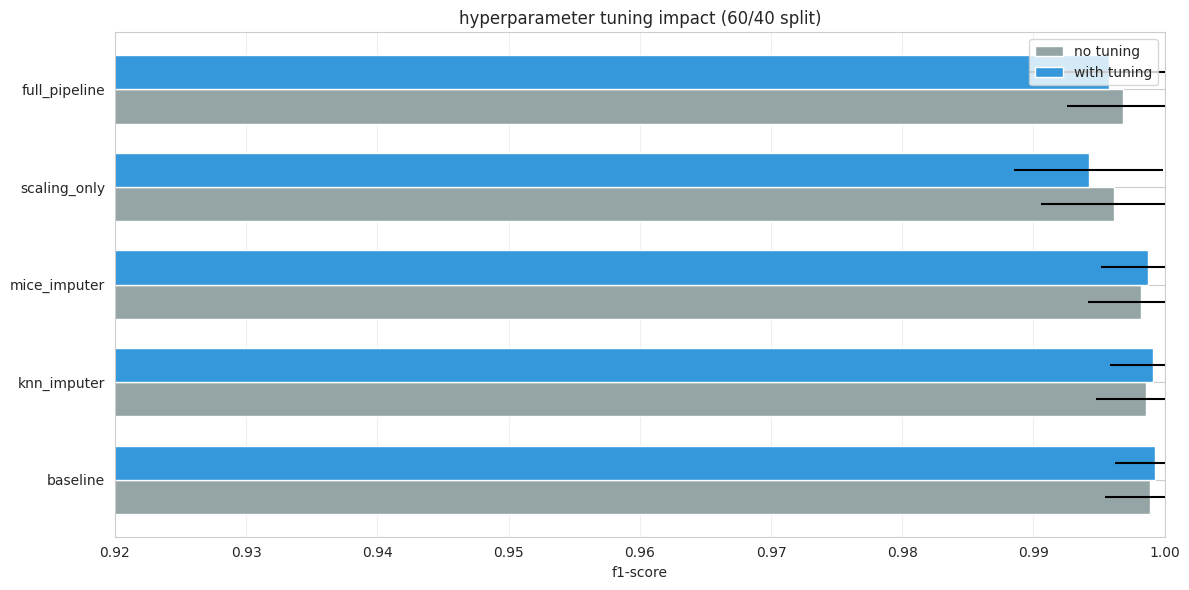

In [124]:
fig, ax = plt.subplots(figsize=(12, 6))

names = list(tuning_no_tuning.keys())
x = np.arange(len(names))
width = 0.35

means_no = [tuning_no_tuning[n]['mean'] for n in names]
stds_no = [tuning_no_tuning[n]['std'] for n in names]
means_with = [tuning_with_tuning[n]['mean'] for n in names]
stds_with = [tuning_with_tuning[n]['std'] for n in names]

ax.barh(x - width/2, means_no, width, xerr=stds_no, label='no tuning', color='#95a5a6')
ax.barh(x + width/2, means_with, width, xerr=stds_with, label='with tuning', color='#3498db')

ax.set_yticks(x)
ax.set_yticklabels(names)
ax.set_xlabel('f1-score')
ax.set_title('hyperparameter tuning impact (60/40 split)')
ax.legend()
ax.set_xlim([0.92, 1.0])
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_60_40.png', dpi=150)
plt.show()

## hyperparameter tuning impact (60/40 split)